In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv(r'churn_data.csv')
print(df.head())

   CustomerID  Age  Gender  Tenure  MonthlyCharges    ContractType  \
0           1   49    Male       4           88.35  Month-to-Month   
1           2   43    Male       0           36.67  Month-to-Month   
2           3   51  Female       2           63.79  Month-to-Month   
3           4   60  Female       8          102.34        One-Year   
4           5   42    Male      32           69.01  Month-to-Month   

  InternetService  TotalCharges TechSupport Churn  
0     Fiber Optic        353.40         Yes   Yes  
1     Fiber Optic          0.00         Yes   Yes  
2     Fiber Optic        127.58          No   Yes  
3             DSL        818.72         Yes   Yes  
4             NaN       2208.32          No   Yes  


In [11]:
def drop_columns(df):
    return df.drop(columns=["CustomerID", "TotalCharges"], errors="ignore")

df = drop_columns(df)

print(df.head())

   Age  Gender  Tenure  MonthlyCharges    ContractType InternetService  \
0   49    Male       4           88.35  Month-to-Month     Fiber Optic   
1   43    Male       0           36.67  Month-to-Month     Fiber Optic   
2   51  Female       2           63.79  Month-to-Month     Fiber Optic   
3   60  Female       8          102.34        One-Year             DSL   
4   42    Male      32           69.01  Month-to-Month             NaN   

  TechSupport Churn  
0         Yes   Yes  
1         Yes   Yes  
2          No   Yes  
3         Yes   Yes  
4          No   Yes  


In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              1000 non-null   int64  
 1   Gender           1000 non-null   object 
 2   Tenure           1000 non-null   int64  
 3   MonthlyCharges   1000 non-null   float64
 4   ContractType     1000 non-null   object 
 5   InternetService  703 non-null    object 
 6   TechSupport      1000 non-null   object 
 7   Churn            1000 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 62.6+ KB
None


In [13]:
def check_nulls(df):
 return df.isnull().sum()

print("Null values in each column:\n")
print(check_nulls(df))


Null values in each column:

Age                  0
Gender               0
Tenure               0
MonthlyCharges       0
ContractType         0
InternetService    297
TechSupport          0
Churn                0
dtype: int64


In [14]:
df.dropna(inplace=True)

In [15]:
df.shape

(703, 8)

In [16]:
# Value counts for categorical columns

def categorical_summary(df):
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    for col in cat_cols:
        print(f"\nValue Counts for {col}:")
        print(df[col].value_counts())


print("=== Categorical Columns Summary ===")
categorical_summary(df)

=== Categorical Columns Summary ===

Value Counts for Gender:
Gender
Female    381
Male      322
Name: count, dtype: int64

Value Counts for ContractType:
ContractType
Month-to-Month    353
One-Year          199
Two-Year          151
Name: count, dtype: int64

Value Counts for InternetService:
InternetService
Fiber Optic    395
DSL            308
Name: count, dtype: int64

Value Counts for TechSupport:
TechSupport
Yes    506
No     197
Name: count, dtype: int64

Value Counts for Churn:
Churn
Yes    586
No     117
Name: count, dtype: int64


In [17]:
# Summary statistics for numerical columns

def numerical_summary(df):
    print("\nNumerical Columns Summary:\n")
    print(df.describe())


print("\n=== Numerical Columns Summary ===")
numerical_summary(df)


=== Numerical Columns Summary ===

Numerical Columns Summary:

              Age      Tenure  MonthlyCharges
count  703.000000  703.000000      703.000000
mean    44.516358   19.056899       73.802006
std      9.875115   19.040358       26.037609
min     12.000000    0.000000       30.000000
25%     38.000000    5.000000       51.070000
50%     45.000000   13.000000       73.560000
75%     51.000000   27.000000       95.775000
max     83.000000  122.000000      119.960000


# EDA Insights for Churn

In [18]:
# Encode categorical target column 'Churn'

def encode_churn(df):
    if 'Churn' in df.columns:
         # Map Yes/No to 1/0
        df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

        print("\nEncoded:")
    print(df['Churn'].value_counts())

# Run encoding
encode_churn(df)


Encoded:
Churn
1    586
0    117
Name: count, dtype: int64


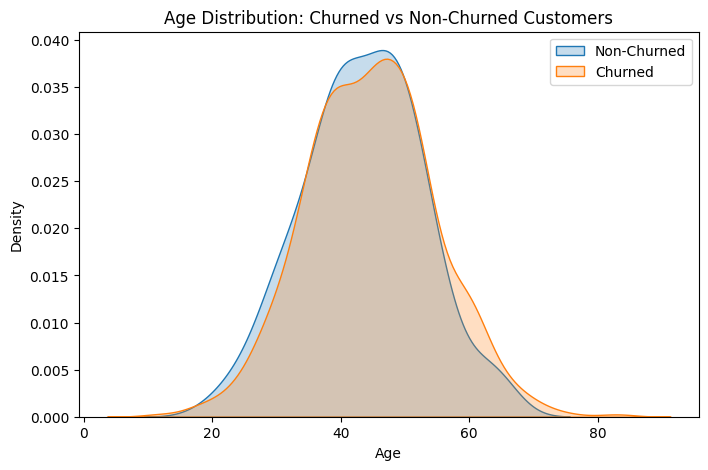

In [19]:
# Age Distribution

def plot_age_distribution(df, target="Churn"):
    if "Age" not in df.columns or target not in df.columns:
        print("Required columns not found in DataFrame.")
        return

    plt.figure(figsize=(8,5))
    sns.kdeplot(df[df[target] == 0]["Age"], label="Non-Churned", shade=True)
    sns.kdeplot(df[df[target] == 1]["Age"], label="Churned", shade=True)

    plt.title("Age Distribution: Churned vs Non-Churned Customers")
    plt.xlabel("Age")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Example usage
plot_age_distribution(df, target="Churn")

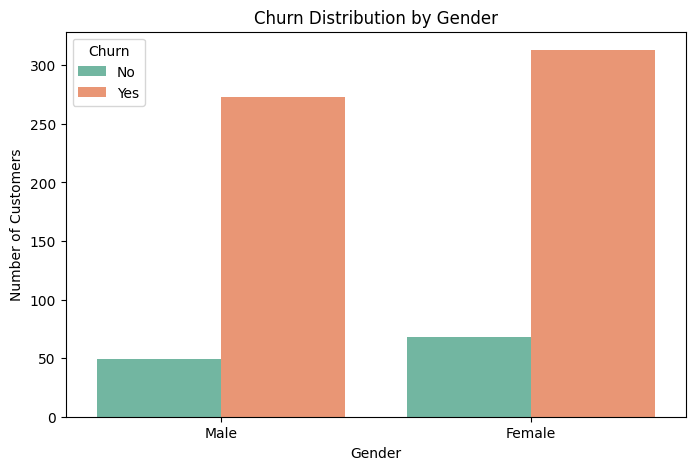

In [20]:
# Churn Distribution by Gender

def plot_gender_churn(df, target="Churn"):
    if "Gender" not in df.columns or target not in df.columns:
        print("Required columns not found in DataFrame.")
        return

    plt.figure(figsize=(8,5))
    sns.countplot(x="Gender", hue=target, data=df, palette="Set2")

    plt.title("Churn Distribution by Gender")
    plt.xlabel("Gender")
    plt.ylabel("Number of Customers")
    plt.legend(title="Churn", labels=["No", "Yes"])
    plt.show()

# Example usage
plot_gender_churn(df, target="Churn")

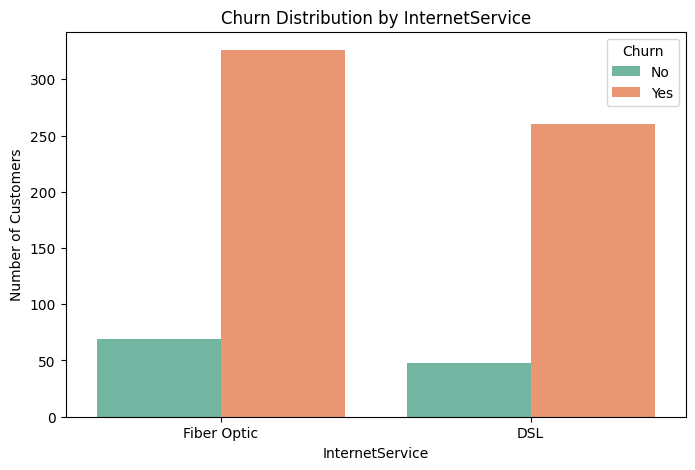

In [21]:
# Churn Distribution by InternetService

def plot_InternetService_churn(df, target="Churn"):
    if "InternetService" not in df.columns or target not in df.columns:
        print("Required columns not found in DataFrame.")
        return

    plt.figure(figsize=(8,5))
    sns.countplot(x="InternetService", hue=target, data=df, palette="Set2")

    plt.title("Churn Distribution by InternetService")
    plt.xlabel("InternetService")
    plt.ylabel("Number of Customers")
    plt.legend(title="Churn", labels=["No", "Yes"])
    plt.show()

# Example usage
plot_InternetService_churn(df, target="Churn")

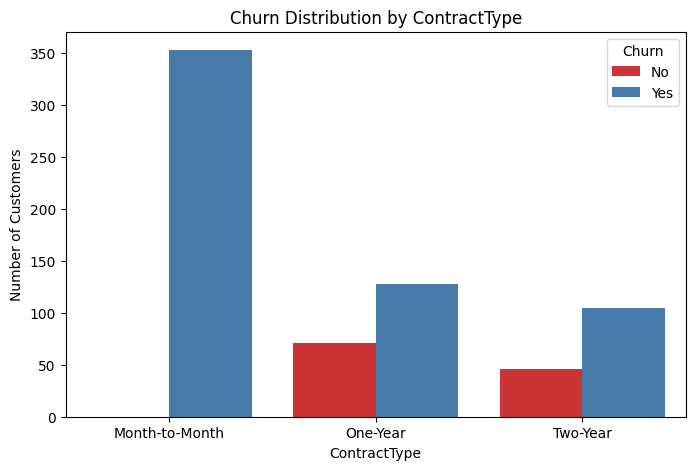

In [22]:
# Churn Distribution by ContractType

def plot_ContractType_churn(df, target="Churn"):
    if "ContractType" not in df.columns or target not in df.columns:
        print("Required columns not found in DataFrame.")
        return

    plt.figure(figsize=(8,5))
    sns.countplot(x="ContractType", hue=target, data=df, palette="Set1")

    plt.title("Churn Distribution by ContractType")
    plt.xlabel("ContractType")
    plt.ylabel("Number of Customers")
    plt.legend(title="Churn", labels=["No", "Yes"])
    plt.show()

# Example usage
plot_ContractType_churn(df, target="Churn")

# Preprocessing

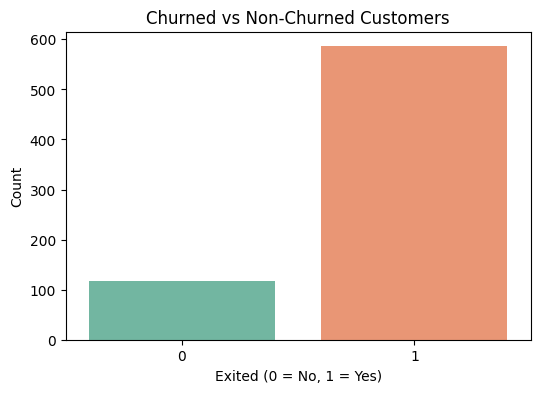

In [23]:
def plot_churn_distribution(df, target="Churn"):
    if target not in df.columns:
        print(f"Target column '{target}' not found in DataFrame.")
        return

    plt.figure(figsize=(6,4))
    sns.countplot(x=target, data=df, palette="Set2")
    plt.title("Churned vs Non-Churned Customers")
    plt.xlabel("Exited (0 = No, 1 = Yes)")
    plt.ylabel("Count")
    plt.show()

plot_churn_distribution(df, target="Churn")

# ML Model Training

In [24]:
from sklearn.impute import SimpleImputer


def remove_outliers(df, cols=None, factor=1.5):
    df = df.copy()
    if cols is None:
        # exclude binary (0/1) dummies
        cols = [c for c in df.select_dtypes(include=np.number).columns if df[c].nunique() > 2]
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df.reset_index(drop=True)


def impute_missing(df):
    df = df.copy()
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns

    # Numeric → median
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())

    # Categorical → most frequent
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    return df


def encode_categoricals(df, drop_first=True):
    df = pd.get_dummies(df, drop_first=drop_first)
    return df


def scale_numericals(df, scaler=None):
    df = df.copy()
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    if scaler is None:
        scaler = StandardScaler()
        df[num_cols] = scaler.fit_transform(df[num_cols])
        return df, scaler
    else:
        df[num_cols] = scaler.transform(df[num_cols])
        return df, scaler


# Full preprocessing pipeline

def preprocessing_pipeline(df, target="Churn", test_size=0.2, random_state=42):

    # Remove outliers
    df = remove_outliers(df)

    # Impute missing values
    df = impute_missing(df)

    # Train-test split
    X = df.drop(columns=["Churn"])
    y = df["Churn"]
    X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

    X_train = encode_categoricals(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)

    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


    X_train, scaler = scale_numericals(X_train)
    X_test, _ = scale_numericals(X_test, scaler=scaler)

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = preprocessing_pipeline(df)
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train set class distribution:\n", y_train.value_counts())
print("\nTest set class distribution:\n", y_test.value_counts())

Train shape: (528, 8)  Test shape: (132, 8)
Train set class distribution:
 Churn
1    442
0     86
Name: count, dtype: int64

Test set class distribution:
 Churn
1    110
0     22
Name: count, dtype: int64


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# ================================
# Logistic Regression
# ================================
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("📌 Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


# Random Forest

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n📌 Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


# Decision Tree

dt = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight="balanced")
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("\n📌 Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

# ================================
# XGBoost
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric="logloss"
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\n📌 XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


📌 Logistic Regression Results:
Accuracy: 0.8863636363636364
ROC-AUC: 0.9318181818181819
              precision    recall  f1-score   support

           0       0.59      1.00      0.75        22
           1       1.00      0.86      0.93       110

    accuracy                           0.89       132
   macro avg       0.80      0.93      0.84       132
weighted avg       0.93      0.89      0.90       132

Confusion Matrix:
 [[22  0]
 [15 95]]

📌 Random Forest Results:
Accuracy: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00       110

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132

Confusion Matrix:
 [[ 22   0]
 [  0 110]]

📌 Decision Tree Results:
Accuracy: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0     

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:20:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


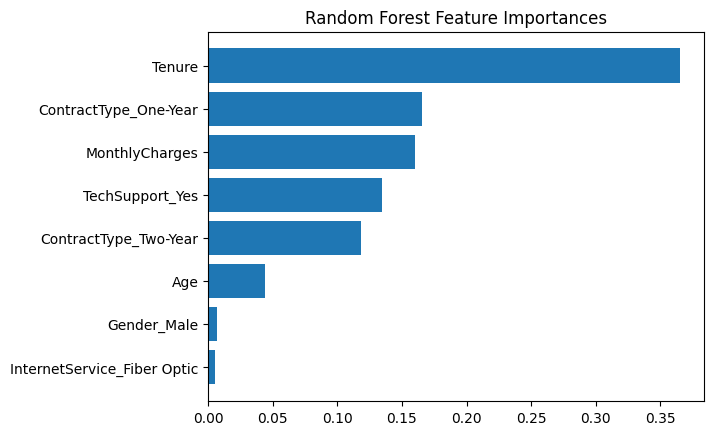

In [26]:
importances = rf.feature_importances_
features = X_train.columns
sorted_idx = importances.argsort()
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title("Random Forest Feature Importances")
plt.show()

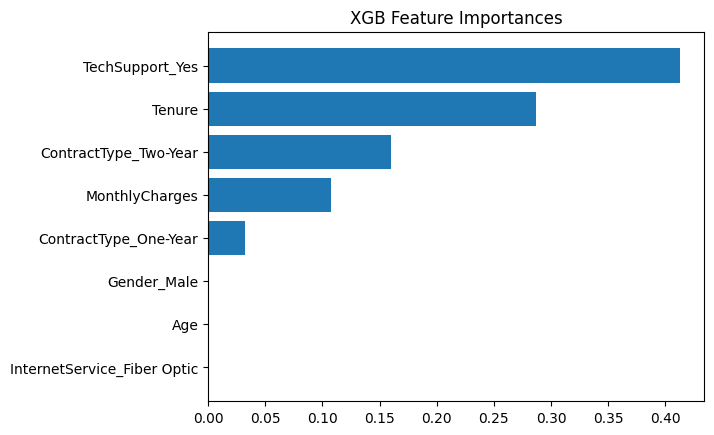

In [27]:
importances = xgb.feature_importances_
features = X_train.columns
sorted_idx = importances.argsort()
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title("XGB Feature Importances")
plt.show()

In [31]:
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
dt = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight="balanced")
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight="balanced")

# Calculate scale_pos_weight for XGBoost
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric="logloss"
)

# --- Create a list of all models to evaluate ---
models = [log_reg, dt, rf, xgb]
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]

# --- Loop through and perform cross-validation ---
print("--- Running 5-Fold Cross-Validation ---")

for model, name in zip(models, model_names):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"\n📌 {name}:")
    print(f"   Fold Scores: {cv_scores}")
    print(f"   Mean CV ROC-AUC: {np.mean(cv_scores):.4f}")
    print(f"   Std Dev of Scores: {np.std(cv_scores):.4f}")

print("\n--- End of Cross-Validation ---")

--- Running 5-Fold Cross-Validation ---

📌 Logistic Regression:
   Fold Scores: [0.98017184 0.96959683 0.96780303 0.96858289 0.97259358]
   Mean CV ROC-AUC: 0.9717
   Std Dev of Scores: 0.0045

📌 Decision Tree:
   Fold Scores: [1.         1.         1.         1.         0.91176471]
   Mean CV ROC-AUC: 0.9824
   Std Dev of Scores: 0.0353

📌 Random Forest:
   Fold Scores: [1. 1. 1. 1. 1.]
   Mean CV ROC-AUC: 1.0000
   Std Dev of Scores: 0.0000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:40:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:40:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:40:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:40:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📌 XGBoost:
   Fold Scores: [1. 1. 1. 1. 1.]
   Mean CV ROC-AUC: 1.0000
   Std Dev of Scores: 0.0000

--- End of Cross-Validation ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:40:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [34]:
regularized_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=7,
    min_samples_split = 10,
    min_samples_leaf = 5,
    bootstrap = True,
    random_state=42,
    class_weight="balanced"
)

regularized_model.fit(X_train, y_train)
y_pred_final = regularized_model.predict(X_test)


print(f"\n Regularized Random Forest Performance on X_test:")
print(f"   Accuracy on Test Set: {accuracy_score(y_test, y_pred_final):.4f}")

print("\n   Classification Report:")
print(classification_report(y_test, y_pred_final))

print("   Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))


 Final Random Forest Performance on X_test:
   Accuracy on Test Set: 1.0000

   Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00       110

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132

   Confusion Matrix:
[[ 22   0]
 [  0 110]]
